# Twitter Analytics - iPhone X vs. Samsung Galaxy S9.
#### 

## Table of Contents

#### [Data Collection Methodology](#data_collect)

#### [Descriptive Analytics](#sect_1)


#### [Content Analytics](#sect_2)


#### [Network Analytics](#sect_3)

<br>
<br>


In [1]:
import tweepy
import csv
import time
import json
import pandas as pd
import re
import numpy as np

from collections import Counter
from operator import itemgetter
from itertools import combinations

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from pandas.io.json import json_normalize
import ast

# Import TextBlob for sentiment analysis
from textblob import TextBlob
from textblob import Word

from IPython.display import HTML, display, Image

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 250
pd.options.display.float_format = '{:,.4f}'.format

#### Language Codes List

In [3]:
#Language Codes Lookup List
#pip install datapackage
from datapackage import Package

#package = Package('https://datahub.io/core/language-codes/datapackage.json')
#I loaded datapackage.json locally
package = Package('data/datapackage.json')

# print list of all resources if needed:
#print(package.resource_names)

#Get language codes
res=package.get_resource('language-codes')
#res=package.get_resource('language-codes-full')
langlists=res.table.read()

# Use dict comprehension to allow lookup of language by code
lang_codes={d[0]: d[1] for d in langlists}

#Add some old non-standard codes
lang_codes.update({'und': 'Undetermined','in': 'Indonesian','iw': 'Hebrew'})

C:\ProgramData\Anaconda2\lib\site-packages\datapackage\resource.py:408: UserWarning: Property "resource.table" is deprecated. Please use "resource.iter/read" directly.
  UserWarning)


#### Now we can lookup actual language name by its code found in tweet metadata

In [4]:
# Test language code lookup
lang_codes['sv']

u'Swedish'


### Read Raw Tweets

In [5]:
import json

filename='data/IPhoneXSamsungS9.json'


with open(filename, 'r') as f:
    line = f.readline() # read only the first tweet/line
    tweet = json.loads(line) # load it as Python dictionary
    print(json.dumps(tweet, indent=4)) 
    
# the original data from Twitter looks like below.
f.close()

{
    "quote_count": 0, 
    "contributors": null, 
    "truncated": false, 
    "text": "Todos querr\u00e1n saber el secreto detr\u00e1s de tus fotos. #GalaxyS9 https://t.co/uAHpiVRIF8", 
    "is_quote_status": false, 
    "in_reply_to_status_id": null, 
    "reply_count": 0, 
    "id": 987783049868955654, 
    "favorite_count": 0, 
    "entities": {
        "user_mentions": [], 
        "symbols": [], 
        "hashtags": [
            {
                "indices": [
                    52, 
                    61
                ], 
                "text": "GalaxyS9"
            }
        ], 
        "urls": [], 
        "media": [
            {
                "additional_media_info": {
                    "monetizable": false
                }, 
                "expanded_url": "https://twitter.com/samsungmobilemx/status/987783049868955654/video/1", 
                "display_url": "pic.twitter.com/uAHpiVRIF8", 
                "url": "https://t.co/uAHpiVRIF8", 
                "medi

#### Read file and separate by iPhone X, Samsung S9, or both.

In [6]:
count_samsungs9=0
count_iphonex=0
count_both=0
tweets_both = []
tweets_samsungs9 = []
tweets_iphone = []

with open(filename, 'r') as f:
    for line in f:
        if ( ('galaxys9' in line.lower())|('samsungs9' in line.lower()) | ('galaxy s9' in line.lower())|
            ('samsung s9' in line.lower())  ) & (('iphone x' in line.lower())|('iphonex' in line.lower()) ):
            count_both = count_both+1
            try:
                # List of tweets with both iPhone X and Samsung S9
                tweets_both.append(json.loads(line))
            except:
                pass
        elif ( ('galaxys9' in line.lower())|('samsungs9' in line.lower()) | ('galaxy s9' in line.lower())|
            ('samsung s9' in line.lower())  ):
            count_samsungs9 = count_samsungs9+1
            try:
                # List of tweets with Samsung S9
                tweets_samsungs9.append(json.loads(line))
            except:
                pass
        elif (('iphone x' in line.lower())|('iphonex' in line.lower()) ) :
            count_iphonex = count_iphonex+1
            try:
                # List of tweets with iPhone X
                tweets_iphone.append(json.loads(line))
            except:
                pass
            
    f.close()
print "%s tweets loaded related to both iPhoneX and Samsung S9" %(count_both)
print "%s tweets loaded related to Samsung S9" %(count_samsungs9)
print "%s tweets loaded related to iPhoneX" %(count_iphonex)



701 tweets loaded related to both iPhoneX and Samsung S9
8168 tweets loaded related to Samsung S9
26458 tweets loaded related to iPhoneX


#### Get languages for tweets

In [7]:
lang_both=[]
lang_iphone=[]
lang_samsungs9=[]

for tweet in tweets_both:
    #print tweet['lang']
    lang_both.append(tweet['lang'])
    
for tweet in tweets_iphone:
    #print tweet['lang']
    lang_iphone.append(tweet['lang'])

for tweet in tweets_samsungs9:
#    #print tweet['lang']
    lang_samsungs9.append(tweet['lang'])


#### Language frequency counts

In [8]:

#Count frequency of languages for tweets with both iPhone X and Samsung S9
count_lang_both = Counter(lang_both)
#print count_lang_both

#Count frequency of languages for tweets with iPhone X
count_lang_iphone = Counter(lang_iphone)
#print count_lang_iphone

#Count frequency of languages for tweets with Samsung S9
count_lang_samsungs9 = Counter(lang_samsungs9)
#print count_lang_samsungs9



In [9]:
#Language counts for Tweets with both iPhone X and Samsung S9
count_lang_both.items()
df_count_lang_both = pd.DataFrame(count_lang_both.items())
df_count_lang_both.rename(columns = {0: 'Language Code',1:'Number Tweets'},inplace=True)
df_count_lang_both['Language Name']=df_count_lang_both['Language Code'].apply(lambda x: lang_codes[x] )
print "Number of languages in tweets containing both iPhone X and Samsung S9: %s" % len(df_count_lang_both)
df_count_lang_both.sort_values(by='Number Tweets', ascending=False)

Number of languages in tweets containing both iPhone X and Samsung S9: 18


,Language Code,Number Tweets,Language Name
2,en,462,English
13,in,69,Indonesian
17,es,59,Spanish; Castilian
16,ja,31,Japanese
5,de,16,German
12,th,13,Thai
3,pt,11,Portuguese
1,fr,8,French
11,und,7,Undetermined
0,ru,7,Russian


In [10]:
#Language counts for Tweets with iPhone X
count_lang_iphone.items()
df_count_lang_iphone = pd.DataFrame(count_lang_iphone.items())
df_count_lang_iphone.rename(columns = {0: 'Language Code',1:'Number Tweets'},inplace=True)
df_count_lang_iphone['Language Name']=df_count_lang_iphone['Language Code'].apply(lambda x: lang_codes[x] )
print "Number of languages in tweets containing iPhone X: %s" % len(df_count_lang_iphone)
df_count_lang_iphone.sort_values(by='Number Tweets', ascending=False)


Number of languages in tweets containing iPhone X: 49


,Language Code,Number Tweets,Language Name
1,en,12712,English
38,ja,5126,Japanese
22,tl,1796,Tagalog
17,pt,1619,Portuguese
14,es,1290,Spanish; Castilian
11,in,772,Indonesian
24,th,627,Thai
27,fr,512,French
30,de,380,German
44,und,320,Undetermined


In [11]:
#Language counts for Tweets with Samsung S9
df_count_lang_samsungs9 = pd.DataFrame(count_lang_samsungs9.items())
df_count_lang_samsungs9.rename(columns = {0: 'Language Code',1:'Number Tweets'},inplace=True)
df_count_lang_samsungs9['Language Name']=df_count_lang_samsungs9['Language Code'].apply(lambda x: lang_codes[x] )
print "Number of languages in tweets containing Samsung S9: %s" % len(df_count_lang_samsungs9)
df_count_lang_samsungs9.sort_values(by='Number Tweets', ascending=False)


Number of languages in tweets containing Samsung S9: 40


,Language Code,Number Tweets,Language Name
1,en,3663,English
15,pt,1470,Portuguese
25,fr,931,French
12,es,864,Spanish; Castilian
37,und,229,Undetermined
9,in,159,Indonesian
27,de,138,German
4,ca,104,Catalan; Valencian
34,ja,76,Japanese
8,ar,74,Arabic


# iphone descriptive analytics

In [15]:
print 'Total Number of iPhone Tweets:' len(tweets_iphone)

26458


In [22]:
from collections import Counter

iphone_screen_names = [T['user']['screen_name'] for T in tweets_iphone]

iphone_users = Counter(screen_names)

In [23]:
print 'Print Number of unique users: ' + str(len(iphone_users))

Print Number of unique users: 21541


In [24]:
# top 10 most active tweeters
iphone_users.most_common(10)

[(u'JustMrLoloN', 70),
 (u'PPP_isesaki', 54),
 (u'nanoed', 50),
 (u'iPhone8andx', 50),
 (u'perfect_cart', 45),
 (u'Vgadgetshow', 41),
 (u'Jonathanamorcit', 31),
 (u'smanavi_info', 31),
 (u'Minashopp_', 28),
 (u'Petrichorcases', 27)]

In [50]:
#orginal vs retweets 
iphone_originaltweets = []
iphone_original_tweet_count = 0
iphone_retweet_tweet_count = 0

for tweet in tweets_iphone:
    if 'rt @' not in tweet['text'].lower():
        iphone_originaltweets.append(tweet)
        iphone_original_tweet_count +=1
    else:
        iphone_retweet_tweet_count+=1
        
print "Number of original tweets: "+ str(iphone_original_tweet_count)
print "Number of retweets: "+ str(iphone_retweet_tweet_count)

Number of original tweets: 10521
Number of retweets: 15937


In [63]:
# of mentions
iphone_user_mentions = []


for tweet in tweets_iphone:
    for mention in tweet['entities']['user_mentions']:
        iphone_user_mentions.append(mention)

        
print 'Number of Mentions: ' + str(len(iphone_user_mentions))

Number of Mentions: 22516


In [89]:
#top 10m most common user mentions

iphone_user_mentions_df = pd.DataFrame(iphone_user_mentions)
print 'Most Popular User Mentions:'
iphone_user_mentions_df['screen_name'].value_counts().head(10)

Most Popular User Mentions:


GiveawayPluss    2404
giveawaycntrl    1767
BelleLife_gc     1521
IzwanHs          1149
lorynegracex     1107
_mominz          1004
YouTube           407
kalluxrz          384
inesds_c          380
GladysSeara       357
Name: screen_name, dtype: int64

In [96]:
#most common hash tags using english tweets
iphone_hashtags = []

for tweet in tweets_iphone:
    if tweet['lang'] == 'en':
        for hashtag in tweet['entities']['hashtags']:
             iphone_hashtags.append(hashtag)


iphone_hashtags_df = pd.DataFrame(iphone_hashtags)
#remove iPhoneX and iphonex hashtags
iphone_hashtags_df = iphone_hashtags_df[iphone_hashtags_df.text != 'iPhoneX']
iphone_hashtags_df = iphone_hashtags_df[iphone_hashtags_df.text != 'iphonex']
print 'Most Popular English Hashtags:'
iphone_hashtags_df['text'].value_counts().head(10)

Most Popular English Hashtags:


JBJจังหวะซิทคอม     1005
iPhone8              476
iPhone8Plus          389
iPhone               233
giveaway             109
obiwezyisyourguy      98
Telegram              87
wallpaper             85
iphone                80
wallpapers            78
Name: text, dtype: int64

In [99]:
#most common URLs in english tweets
iphone_urls = []

for tweet in tweets_iphone:
    if tweet['lang'] == 'en':
        for url in tweet['entities']['urls']:
             iphone_urls.append(url)

iphone_urls_df = pd.DataFrame(iphone_urls)

print 'Most Popular English Hashtags:'
iphone_urls_df['url'].value_counts().head(10)

Most Popular English Hashtags:


https://t.co/Zswf2VzzCy    293
https://t.co/XzdSESqEPM    239
https://t.co/tjcD8nfABU    195
https://t.co/4M6JaY9Mrm     84
https://t.co/kNziLZtbcX     39
https://t.co/mESHuWv1Yl     32
https://t.co/MV6iAXX2lk     27
https://t.co/XNY3hOH7Fr     26
https://t.co/NoBemYWJ7o     26
https://t.co/wRU7GbViGp     22
Name: url, dtype: int64

# iPhone Content Analytics using English Tweets

In [100]:
# import packages for text processing
import csv
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

#import pyLDAvis.gensim

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)  # To ignore all warnings that arise here to enhance clarity

C:\ProgramData\Anaconda2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [103]:
#gather list of text of english tweets:
iphone_english_tweet_text = []

for i in tweets_iphone:
    if i['user']['lang'] == "en":
        iphone_english_tweet_text.append(i)
#print "Total number of english tweets: " + str(len(iphone_english_tweet_text))

In [147]:
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

#convert lists to strings
iphone_english_tweet_text_str = str(iphone_english_tweet_text)

#lowercase
iphone_tokens = iphone_english_tweet_text_str.lower()

#tokenize
iphone_tokens = iphone_tokens.split()

#Remove stopwords
iphone_more_stopwords = set(('iphonex', 'iphone x','dont','want','like'))
iphone_stoplist = set(stopwords.words('english')) | iphone_more_stopwords
iphone_tokens = (word for word in iphone_tokens if word not in iphone_stoplist)


# Filter non-alphanumeric chars from tokens
iphone_tokens = (ch.lower() for ch in iphone_tokens if ch.isalpha())

#remove short words
iphone_tokens = (word for word in iphone_tokens if len(word) >= 4)


#compute frequency distribution for all the bigrams in the text
iphone_fdist = nltk.FreqDist(iphone_tokens)
    


In [139]:
#print 50 most commond terms
iphone_fdist.most_common(50)

[('iphone', 23886),
 ('giveaway', 9877),
 ('time', 9817),
 ('post', 5339),
 ('light', 4884),
 ('notification', 4148),
 ('shipping', 4048),
 ('international', 4007),
 ('huawei', 3736),
 ('mode', 3610),
 ('winners', 3599),
 ('morning', 3595),
 ('dark', 3590),
 ('areas', 3579),
 ('shots', 3579),
 ('apply', 3579),
 ('purchase', 2766),
 ('follow', 2522),
 ('para', 2517),
 ('lang', 2436),
 ('direct', 2339),
 ('tiwala', 2279),
 ('lucky', 2256),
 ('magkaiphone', 2220),
 ('limited', 1967),
 ('retweet', 1820),
 ('link', 1667),
 ('phone', 1645),
 ('first', 1425),
 ('join', 1409),
 ('bebenang', 1260),
 ('apple', 1236),
 ('brand', 1190),
 ('instagram', 1031),
 ('click', 1031),
 ('proof', 1031),
 ('plus', 1008),
 ('random', 953),
 ('rakan', 929),
 ('gift', 864),
 ('budak', 780),
 ('darjah', 778),
 ('love', 741),
 ('twitter', 710),
 ('case', 710),
 ('following', 657),
 ('mean', 613),
 ('life', 601),
 ('chance', 566),
 ('orang', 564)]

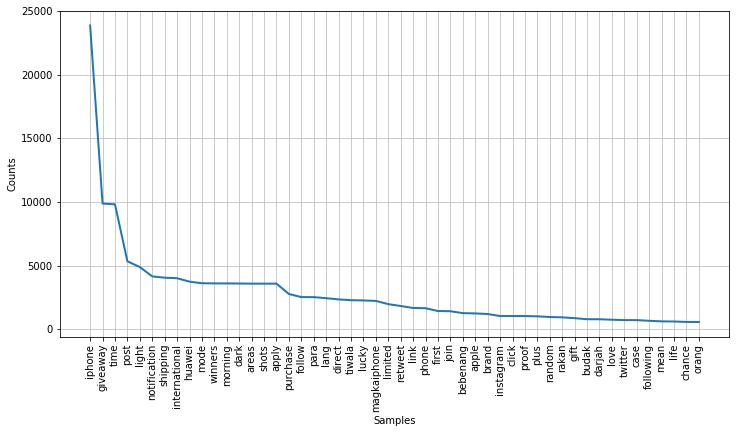

In [130]:
#auto graph of 50 most common
plt.figure(figsize=(12,6))
iphone_fdist.plot(50)

## Insert Wordcloud here.

In [146]:
#most common hash tags using english tweets
iphone_hashtags = []

for tweet in tweets_iphone:
    if tweet['lang'] == 'en':
        for hashtag in tweet['entities']['hashtags']:
             iphone_hashtags.append(hashtag)


iphone_hashtags_df = pd.DataFrame(iphone_hashtags)
#remove iPhoneX and iphonex hashtags
iphone_hashtags_df = iphone_hashtags_df[iphone_hashtags_df.text != 'iPhoneX']
iphone_hashtags_df = iphone_hashtags_df[iphone_hashtags_df.text != 'iphonex']
print 'Most Popular English Hashtags:'
iphone_hashtags_df['text'].value_counts().head(10)

Most Popular English Hashtags:


JBJจังหวะซิทคอม     1005
iPhone8              476
iPhone8Plus          389
iPhone               233
giveaway             109
obiwezyisyourguy      98
Telegram              87
wallpaper             85
iphone                80
wallpapers            78
Name: text, dtype: int64

### iPhone Topic Modeling